# 【第３回 課題2　解答シート】Neural style transfer
解答用のシートです．解答はこちらを改変して行って下さい．　

In [1]:
# UEC 共通設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0,..., "7":GPU7 を使用

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else:
    datadir="/usr/local/class/object/media/"
    
# 結果を出力するディレクトリを作成
outdir='result'
os.makedirs(outdir, exist_ok=True)

In [2]:
import keras

Using TensorFlow backend.


using GPU: 2


In [3]:
from keras.preprocessing.image import load_img, img_to_array

# コンテント画像のファイル名です．
target_image_path = 'img/turtle.jpg'

# スタイル画像のファイル名です．
# img/ に night-style.jpg, scream-style.jpg, wave-style.jpg がサンプルとしてあります．
style_reference_image_path = 'img/wave-style.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [4]:
import numpy as np
from keras.applications import vgg16

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

<!--
Let's set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder 
that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy 
arrays. The style reference and target image are static, and thus defined using `K.constant`, while the values contained in the placeholder 
of the generated image will change over time.-->

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [7]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [10]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [11]:
from scipy.optimize import fmin_l_bfgs_b
import time

iterations = 30 # 繰り返し回数

x = preprocess_image(target_image_path)
x = x.flatten()
st=time.time()
for i in range(iterations):
    if i%5==0:
        print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    if i%5==0:
        print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    if i%5==0:   
        end_time = time.time()
        print('Iteration %d completed in %ds (total time %ds)' % (i, end_time - start_time, end_time-st))

Start of iteration 0
Current loss value: 2189707000.0
Iteration 0 completed in 7s (total time 7s)
Start of iteration 5
Current loss value: 157071790.0
Iteration 5 completed in 4s (total time 29s)
Start of iteration 10
Current loss value: 85619770.0
Iteration 10 completed in 4s (total time 53s)
Start of iteration 15
Current loss value: 58451724.0
Iteration 15 completed in 4s (total time 76s)
Start of iteration 20
Current loss value: 43842664.0
Iteration 20 completed in 4s (total time 100s)
Start of iteration 25
Current loss value: 36729280.0
Iteration 25 completed in 4s (total time 124s)


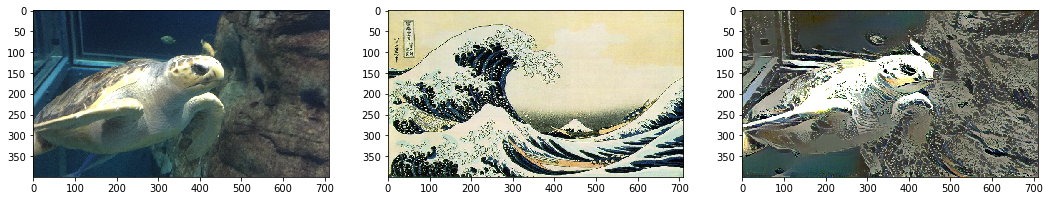

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

plt.figure(figsize=(18,6))

# Content image
plt.subplot(131)
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))

# Style image
plt.subplot(132)
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))

# Generate image
plt.subplot(133)
plt.imshow(img)

plt.savefig(outdir+'/turtle-style3.png') 
plt.show()

<!--
Keep in mind that what this technique achieves is merely a form of image re-texturing, or texture transfer. It will work best with style 
reference images that are strongly textured and highly self-similar, and with content targets that don't require high levels of details in 
order to be recognizable. It would typically not be able to achieve fairly abstract feats such as "transferring the style of one portrait to 
another". The algorithm is closer to classical signal processing than to AI, so don't expect it to work like magic!

Additionally, do note that running this style transfer algorithm is quite slow. However, the transformation operated by our setup is simple 
enough that it can be learned by a small, fast feedforward convnet as well -- as long as you have appropriate training data available. Fast 
style transfer can thus be achieved by first spending a lot of compute cycles to generate input-output training examples for a fixed style 
reference image, using the above method, and then training a simple convnet to learn this style-specific transformation. Once that is done, 
stylizing a given image is instantaneous: it's a just a forward pass of this small convnet.


## Take aways

* Style transfer consists in creating a new image that preserves the "contents" of a target image while also capturing the "style" of a 
reference image.
* "Content" can be captured by the high-level activations of a convnet.
* "Style" can be captured by the internal correlations of the activations of different layers of a convnet.
* Hence deep learning allows style transfer to be formulated as an optimization process using a loss defined with a pre-trained convnet.
* Starting from this basic idea, many variants and refinements are possible!
-->

## 課題2

以下の小問の(1)を解答せよ． **(課題提出には解答シートを使って下さい．)**

1. 上記以外のコンテンツ画像2枚，スタイル画像2枚について変換してみよ．絵画画像は，[WikiArt](https://www.wikiart.org/) で探すとよい．

解答は課題１と同様に，上記セルを出力ファイル名を変更して繰り返し実行し，以下のセルにmarkdownで出力画像を貼り付けて，解答とせよ．

<img src="result/lion-style1.png" width="960">

<img src="result/lion-style2.png" width="960">

<img src="result/turtle-style1.png" width="960">

<img src="result/turtle-style2.png" width="960">

<img src="result/turtle-style3.png" width="960">

<img src="result/jugon-style1.png" width="960">

<img src="result/jugon-style3f.png" width="960">

# コメント
ライオンと亀の画像は、うまくスタイル変換をすることができた。一方でジュゴンの写真の変換は、元の画像の特徴を残してはいるが、元の画像とは全く異なる、何か別のものになった。これはおそらくジュゴンの色が背景と同化しすぎていることと、ジュゴンという生物が元々体と顔の判別をしにくい体型をしていることに加え判別しにくい姿勢をしていることが原因であると考えられる。また、各写真の変換において元々の画像にはない色が出現している。よってスタイルというのは、濃淡における色づけの比率で成り立っているのだと考えられる。

In [13]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()